# Setup the problem

In [1]:
import casadi as cs

N = 100 
opti = cs.Opti()

# Declare decision variables

In [2]:
X = opti.variable(2, N+1) # state trajectory 
pos = X[0, :]
speed = X[1, :]
U = opti.variable(1, N) # control trajectory 
T = opti.variable() # final time 

# Set the objective

In [3]:
opti.minimize(T)

# Specify system dynamics

In [4]:
def f(x, u):
    # Return a CasADi type (e.g., MX or SX) using vertcat to combine elements
    return cs.vertcat(x[1], u - x[1])

# Set gap closing constraints, picking RK as integration method 

In [5]:
dt = T/N # length of a control interval
for k in range(N):
    # Using RK-4 
    k1 = f(X[:, k], U[:, k])
    k2 = f(X[:, k] + dt/2 * k1, U[:, k])
    k3 = f(X[:, k] + dt/2 * k2, U[:, k])
    k4 = f(X[:, k] + dt*k3, U[:, k])
    x_next = X[:, k] + dt/6 * (k1 + 2*k2 + 2*k3 + k4)
    opti.subject_to(X[:, k+1] == x_next)

# Set Path constraints

In [6]:
def limit(x):
    return 1 - cs.sin(2 * cs.pi * x) / 2

opti.subject_to(speed<=limit(pos)) # track speed limit 

# IMP: Need to separate these constraints 
opti.subject_to(0<=U) # control input greater than 0
opti.subject_to(U<=1) # control input is limited to less than 1

# Set Boundary conditions

In [7]:
opti.subject_to(pos[0]==0) # start at pos 0 
opti.subject_to(speed[0]==0) # ... from stand-still 
opti.subject_to(pos[N]==1) # finish line at position 1
opti.subject_to(T>=0) # time must be positive

# Provide initial guesses for the solver

In [8]:
opti.set_initial(speed, 1)
opti.set_initial(T, 1)

# Solve the NLP using IPOPT

In [9]:
opti.solver('ipopt')
sol = opti.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:      903
Number of nonzeros in inequality constraint Jacobian.:      403
Number of nonzeros in Lagrangian Hessian.............:      302

Total number of variables............................:      303
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      203
Total number of inequality c

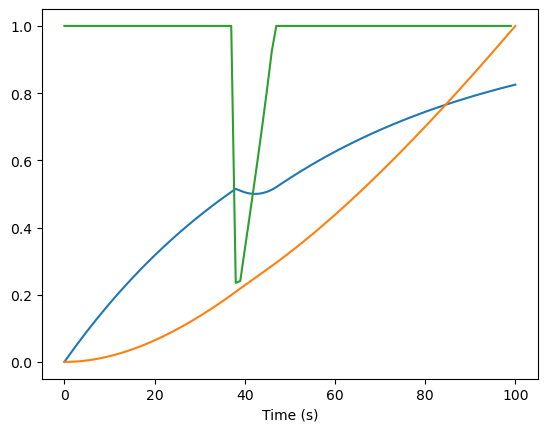

In [13]:
import matplotlib.pyplot as plt

plt.plot(sol.value(speed))
plt.plot(sol.value(pos))
plt.plot(sol.value(U))
plt.xlabel('Time (s)')
plt.show()